# Assign Free Stream and Turbulence

For each FLORIS model and each saved SOWFA simulation, determine the best free stream wind as that which minimizes the error relative to the upstream-most turbines power production

Note the subtle difference is mostly connected to # of points on rotor

Then use the previously defined TI function to determine an ambient TI using the power method applied to upstream-most turbines.  Note that the new Gauss versions (Gauss and Gauss_Tune) will use this, while Gauss_Legacy will use the fit values

In [1]:
import matplotlib.pyplot as plt
import floris.tools as wfct
import numpy as np
import pandas as pd
import copy
import seaborn as sns
import pickle
from scipy.optimize import minimize
from scipy.interpolate import interp1d

## Load FLORIS models and SOWFA DATA

In [2]:
df = pickle.load( open( "sowfa_03.p", "rb" ) )
fi_dict = pickle.load( open( "floris_models.p", "rb" ) )

In [3]:
# Limit to less than 6 turbines for now
# df = df[df.num_turbines < 6]

## Determine the freestream

In [4]:
(fi, floris_color, floris_marker, floris_label) = fi_dict['g']
fi.reinitialize_flow_field(layout_array=[[0],[0]])
ws_array = np.arange(5,16,0.1)

powers = np.zeros_like(ws_array)
for w_idx, ws in enumerate(ws_array):
    fi.reinitialize_flow_field(wind_speed=[ws])
    fi.calculate_wake()
    powers[w_idx] = fi.get_turbine_power()[0] / 1000.

In [5]:
ws

15.899999999999961

In [6]:
ws_interp = interp1d(powers, ws_array, fill_value='extrapolate')

In [7]:
x = ws_interp(5)

In [8]:
float(x)

3.5741903402353943

In [9]:
## Work out free-stream wind speed for each fi

for floris_key in fi_dict:
    (fi, floris_color, floris_marker, floris_label) = fi_dict[floris_key]
    print(floris_label)

    free_stream_ws = []
    for i, row in df.iterrows():

        # Match the layout
        fi.reinitialize_flow_field(layout_array=[row.layout_x,row.layout_y])

        # Grab the upstream turbine
        wake_table = row.wake_table
        upstream_indicies = np.where(wake_table==0)[0]
        sowfa_power = np.mean(row['power'][upstream_indicies])
        # upstream_columns = ['sowfa_power_%d' % upstream_idx for upstream_idx in upstream_indicies]
        # sowfa_power = np.mean(row[upstream_columns])

        # Find the min error wind speed and assign in
        # result = minimize(power_error, args=(sowfa_power, upstream_indicies, fi),x0=8.0)
        free_stream_ws.append(float(ws_interp(sowfa_power)))

    # Assign into the dataframe
    freestream_name = 'freestream_' + floris_label
    df[freestream_name] = free_stream_ws
        

gauss
gauss_tune
gch_paper
legacy


In [10]:
# Check assigned speeds
df.head()
df_sub = df[['sowfa_U0','Precursor','freestream_gauss','freestream_gauss_tune']]
df_sub = pd.melt(df_sub.dropna(how='any'),id_vars='Precursor').groupby(['Precursor','variable']).agg([np.mean,np.median])

df_sub

value           
                                                              mean     median
Precursor                         variable                                   
neutral_5kmx2kmx1km\n             freestream_gauss        8.114106   8.019179
                                  freestream_gauss_tune   8.114106   8.019179
                                  sowfa_U0                8.000000   8.000000
neutral_5kmx2kmx1km_10mps\n       freestream_gauss       10.229890  10.134049
                                  freestream_gauss_tune  10.229890  10.134049
                                  sowfa_U0               10.000000  10.000000
neutral_5kmx2kmx1km_10mps_lowTI\n freestream_gauss       10.227429  10.087899
                                  freestream_gauss_tune  10.227429  10.087899
                                  sowfa_U0               10.000000  10.000000
neutral_5kmx2kmx1km_11mps_lowTI\n freestream_gauss       10.657662  10.515145
                                  freestream_gauss_tune  10.657662  10.515145
                                  sowfa_U0               11.000000  11.000000
neutral_5kmx2kmx1km_12mps_lowTI\n freestream_gauss       11.960195  11.438502
                                  freestream_gauss_tune  11.960195  11.438502
                                  sowfa_U0               12.000000  12.000000
neutral_5kmx2kmx1km_13mps\n       freestream_gauss       11.994321  11.927877
                                  freestream_gauss_tune  11.994321  11.927877
                                  sowfa_U0               13.000000  13.000000
neutral_5kmx2kmx1km_13mps_lowTI\n freestream_gauss       15.057006  15.057006
                                  freestream_gauss_tune  15.057006  15.057006
                                  sowfa_U0               13.000000  13.000000
neutral_5kmx2kmx1km_9mps\n        freestream_gauss        9.063354   8.926487
                                  freestream_gauss_tune   9.063354   8.926487
                                  sowfa_U0                9.000000   9.000000
neutral_5kmx2kmx1km_9mps_lowTI\n  freestream_gauss        9.009374   8.845667
                                  freestream_gauss_tune   9.009374   8.845667
                                  sowfa_U0                9.000000   9.000000
neutral_5kmx2kmx1km_lowTI\n       freestream_gauss        8.127687   8.021910
                                  freestream_gauss_tune   8.127687   8.021910
                                  sowfa_U0                8.000000   8.000000
neutral_5kmx5kmx1km\n             freestream_gauss        8.389584   8.448690
                                  freestream_gauss_tune   8.389584   8.448690
                                  sowfa_U0                8.000000   8.000000
neutral_5kmx5kmx1km_lowTI\n       freestream_gauss        8.246377   8.334978
                                  freestream_gauss_tune   8.246377   8.334978
                                  sowfa_U0                8.000000   8.000000

In [11]:
## Assign free-stream TI directly without referecnce to floris model
free_stream_ti = []
for i, row in df.iterrows():

    # Grab the upstream turbine
    wake_table = row.wake_table
    upstream_indicies = np.where(wake_table==0)[0]
    ti_mean = np.mean(row['ti'][upstream_indicies])
    
    free_stream_ti.append(ti_mean)

# Assign into the dataframe
freestream_name = 'freestream_ti'
df[freestream_name] = free_stream_ti

In [12]:
df.head()

,Precursor,case_name,floris_TI,floris_U0,layout_x,layout_y,num_turbines,path,sim_length,sowfa_TI,...,yaw,power,ti,d_spacing,wake_table,freestream_gauss,freestream_gauss_tune,freestream_gch_paper,freestream_legacy,freestream_ti
casename,,,,,,,,,,,,,,,,,,,,,
c_0,neutral_5kmx2kmx1km\n,c_08_highTI_D05_R-1_y-20,0.09,8.38,"(1000.0, 1630.0)","(1000.0, 937.0)",2,sowfa_library (Paul.fleming@nrel.gov)/full_run...,2000.0,0.1,...,"[-20.0, 0.0]","[1697.0, 1445.7]","[0.09703534975568191, 0.16729992046512362]",5.0,"[0, 1]",8.010363,8.010363,8.010363,8.010363,0.097035
c_1,neutral_5kmx2kmx1km\n,c_08_highTI_D05_R-1_y00,0.09,8.38,"(1000.0, 1630.0)","(1000.0, 937.0)",2,sowfa_library (Paul.fleming@nrel.gov)/full_run...,2000.0,0.1,...,"[0.0, 0.0]","[1937.5, 1072.3]","[0.09297835821594881, 0.17988567028143654]",5.0,"[0, 1]",8.372428,8.372428,8.372428,8.372428,0.092978
c_2,neutral_5kmx2kmx1km\n,c_08_highTI_D05_R-1_y20,0.09,8.38,"(1000.0, 1630.0)","(1000.0, 937.0)",2,sowfa_library (Paul.fleming@nrel.gov)/full_run...,2000.0,0.1,...,"[20.0, 0.0]","[1688.3, 966.6]","[0.0853431860270954, 0.1327437170885774]",5.0,"[0, 1]",7.996701,7.996701,7.996701,7.996701,0.085343
c_3,neutral_5kmx2kmx1km\n,c_08_highTI_D05_R00_y-20,0.09,8.38,"(1000.0, 1630.0)","(1000.0, 1000.0)",2,sowfa_library (Paul.fleming@nrel.gov)/full_run...,2000.0,0.1,...,"[-20.0, 0.0]","[1699.3, 907.2]","[0.09688156249065837, 0.12228484151676836]",5.0,"[0, 1]",8.013952,8.013952,8.013952,8.013952,0.096882
c_4,neutral_5kmx2kmx1km\n,c_08_highTI_D05_R00_y00,0.09,8.38,"(1000.0, 1630.0)","(1000.0, 1000.0)",2,sowfa_library (Paul.fleming@nrel.gov)/full_run...,2000.0,0.1,...,"[0.0, 0.0]","[1938.0, 752.7]","[0.09285372321562335, 0.10368956548356832]",5.0,"[0, 1]",8.373153,8.373153,8.373153,8.373153,0.092854


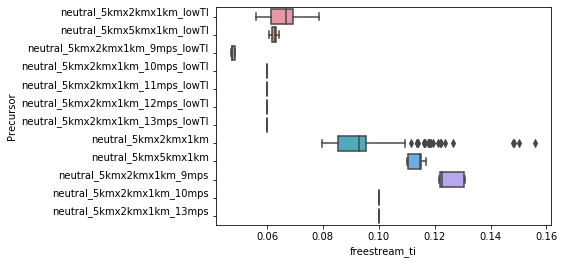

In [18]:
sns.boxplot(data=df.sort_values(['sowfa_TI','sowfa_U0']),x='freestream_ti',y='Precursor')

## AD HOC CORRECTION

This all seems to break down over 9 m/s, so, just use the SOWFA values past there


In [19]:
for floris_key in fi_dict:
    (fi, floris_color, floris_marker, floris_label) = fi_dict[floris_key]
    freestream_name = 'freestream_' + floris_label
    df.loc[df.sowfa_U0>9,freestream_name] = df.sowfa_U0

df.loc[df.sowfa_U0>9,'freestream_ti'] = df.sowfa_TI

In [20]:
## Save

In [21]:
# Save the updated dataframe
pickle.dump( df, open( "sowfa_04.p", "wb" ) )

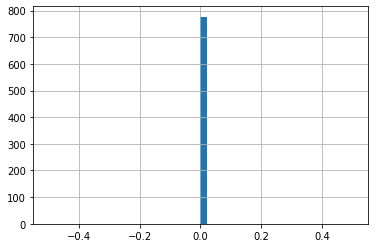

In [22]:
# Compare the distributions
df['difference'] = df.freestream_gauss - df.freestream_legacy
df.difference.hist(bins=50)